# Homework 10
Author: Mao Nishino

The data `data_clust` is a Matlab file containing 13000 observations $x_i \in \mathbb{R}^{640}$ and their labels $y_i$ . The data can be loaded in Python using scipy.io.loadmat and there is a similar package to load the data into R. We will perform k-means clustering using different initialization methods and evaluate the clustering result.

In [137]:
# Import relevant libraries
import numpy as np
import pandas as pd
import scipy as sp
import sklearn.decomposition as sd
import sklearn.cluster as sc
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Load the data
data_clust = sp.io.loadmat('./data_clust.mat')

"""
features is a 13000x640 array where each column is a feature.
labels is a 13000 array which contains labels for each 13000 
samples.
"""

# Reformat the data
features = data_clust['x']
labels = data_clust['y'].squeeze()

# Problem (a)
Perform PCA on the data matrix $X$ and plot the projected points on the first two PCs. Use a different color for each class.

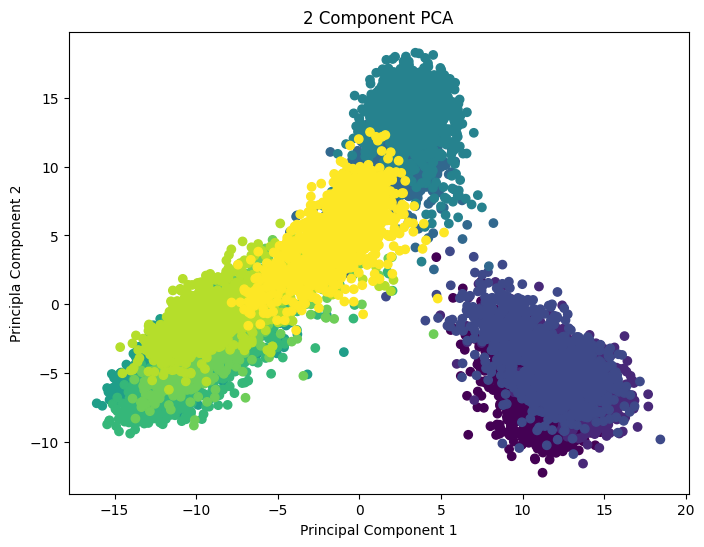

In [46]:
# Do the PCA
pca = sd.PCA(n_components=2)
pcs = pca.fit_transform(features)

# Plot the image
plt.figure(figsize=(8,6))
plt.xlabel('Principal Component 1')
plt.ylabel('Principla Component 2')
plt.title('2 Component PCA')
plt.scatter(pcs[:,0], pcs[:,1], c=labels)
plt.show()

# Problem (b)
Perform $k$-means clustering using one random initialization. Compute the $10  \times  10$ contingency matrix, which is a 2D histogram of the $(y_i, \hat{y}_i)$ combinations. See
`sklearn.metrics.cluster.contingency_matrix` for details. Display the obtained contingency matrix as a grayscale image.

In [154]:
def plot_contingency(conts,
                     title = 'The Contingency Matrix',
                     ylabel = 'Kmeans class'):
    """ The function to plot contingency matrices.

    Args:
    
    conts: List of np.ndarray of shape (#clusters, #clusters)
        A list of contingency matrices.
    
    title: str, default = 'The Contingency Matrix'
        The title of the plot.

    ylabel: str. default = 'Kmeans class'
        The ylabel of the plot.
    """
    fig, axs = plt.subplots(1, len(conts),
                             figsize=(3.1*len(conts), 3.5))
    for i in range(len(conts)):
        if len(conts) > 1:
            ax = axs[i]
            ax.title.set_text(str(i))
        else:
            ax = axs
        ax.imshow(conts[i], cmap='gray')
        ax.xaxis.get_major_locator().set_params(integer=True)
        ax.yaxis.get_major_locator().set_params(integer=True)
    fig.supxlabel('Ground Truth')
    fig.supylabel(ylabel)
    plt.suptitle(title)
    plt.show()
    

def kmeans_contingency(features: np.ndarray,
                        labels: np.ndarray,
                        n_init: int = 1,
                        random_state: int = None,
                        init = 'random'):
    """ Conducts k-means and plots the contingency matrix.
    
    This function is used to solve b) in the HW.

    Args:

    features: np.ndarray of shape (n_samples, n_features)
        The data matrix to do clustering.

    labels: np.ndarray of shape (n_samples,)
        The label of each sample.

    n_init: int, default = 1
        'n_init' parameter for Kmeans.

    random_state: int, default = None
        'random_state' parameter for Kmeans.
        
    init: str or array-like, default = 'random'
        'init' parameter for Kmeans.

    Retruns:
    
    cont: np.ndarray of (n_clusters, n_clusters)
        the contingency matrix.
    
    km_labels: np.ndarray of shape (#samples,)
        the predicted samples.
        This is needed in Problem (d) and forth.
    """

    # Do K-means
    km = sc.KMeans(n_clusters = 10,
                   init = init,
                   n_init=n_init,
                   random_state=random_state)
    km.fit(features)

    # Construct the contingency matrix
    cont = sm.cluster.contingency_matrix(labels, km.labels_)
    return cont, km.labels_

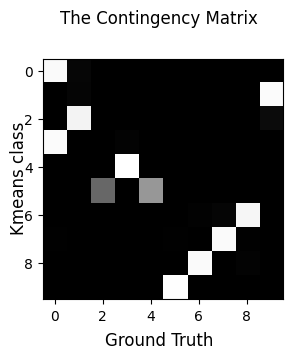

In [146]:
cont, _ = kmeans_contingency(features, 
                          labels,
                          random_state = 0)

plot_contingency([cont])

# Problem (c)
The clustering result is the same up to a permutation of the labels. We will
assign the cluster labels to the true labels by finding a permutation of the labels that maximizes the sum of the diagonal elements on the resulting contingency matrix. For that we will solve the linear sum assignment problem, see
`scipy.optimize.linear_sum_assignment` for details. Use the contingency matrix to solve the linear sum assignment, but be aware that the linear
sum assignment performs a minimization, but we want to maximize the assignment of clusters to labels. Display the contingency matrix obtained after the
permutation of the labels given by the linear sum assignment, which should be
close to a diagonal matrix.

In [126]:
"""
Given two set of points A and B, the optimal assignment prob-
-lem finds the best (optimal in cost) way to assign the points
 in A to points in B when we are given that the cost of assign-
 -ing a point i in A to j in B is C[i,j]. We express the assign-
 -ment by a matrix X[i,j] where X[i,j]=1 when i is assigned to j 
 and 0 otherwise. 

Given an assignment matrix X[i,j], the total cost of assingment is
the sum of C[i,j]X[i,j] for all i,j. In the optimal assignment 
problem, we find X that minimizes the total cost.

In our case, A={the set of kmeans labels}, B={the set of new labels}, 
and we want to find the assignment that maximizes the sum of diagonal
elements in the contingency matrix after renewing the labels.

Let C be a contingency matrix.
Given an assignemnt matrix X[i,j] between A and B, the contingency matrix
after replacing the labels is C @ X where @ is the matrix product.
Thus, the sum of the diagonal element of C@X is
Σ[i,k]C[i,k]X[k,i]
which is equivalent to
Σ[i,k]C^T[k,i]X[k,i] (T means transpose)
or replacing i->j, k->i,
Σ[i,j]C^T[i,j]X[i,j]

Thus, our cost matrix is the transpose of the contingency matrix.
"""

def contingency_optimal_assignment(cont, kmlabel = None, need_label = False):
    """ Solve the optimal assignment problem and displays
    the renewed contingency matrix.

    This solves (c).

    Args:

    cont: np.ndarray of shape (n_clusters, n_clusters)
        The contingency matrix.

    km_label: np.ndarray of shape (#samples,), default = None
        the prediction by kmeans.
        
    need_label: bool, default = False
        if True, outputs renewed labels.

    Returns:

    new_cont: np.ndarray of shape (n_clusters, n_clusters)
        The relabeled contingency matrix.

    new_labels: np.ndarray of shape (#samples,)
        The renewed labels. None if need_label = False.
        This is needed in Problem (d) and forth.

    """
    # Solve optimization
    row_ind, col_ind = sp.optimize.linear_sum_assignment(cont.T,
                                                         maximize=True)

    # Initialize the new contingency matrix
    new_cont = np.empty_like(cont)
    new_labels = None
    # Make a new cont
    new_cont[:, col_ind] = cont[:, row_ind]

    if need_label:
        # Initialize new labels
        new_labels = np.empty_like(kmlabel)
        # For each element in row_ind, replace that element to
        # the corresponding element in col_ind.
        for i in range(len(row_ind)):
            new_labels[kmlabel == row_ind[i]] = col_ind[i]
        
    return new_cont, new_labels

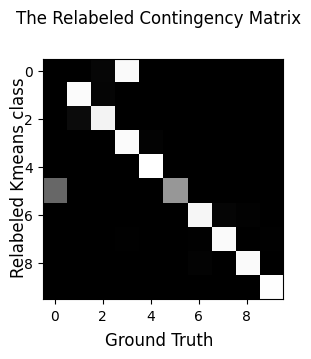

In [147]:
new_cont, _ = contingency_optimal_assignment(cont)
plot_contingency([new_cont],
                 title = 'The Relabeled Contingency Matrix',
                 ylabel = 'Relabeled Kmeans class')

# Problem (d)
Repeat points b) and c) five times with different random initializations and display the 5 obtained original and permuted contingency matrices. In each case
report the accuracy score, which is the sum of the diagonal elements of the permuted contingency matrix divided by the number of observations. Also report
the obtained Adjusted Rand Index (`sklearn.metrics.adjusted_rand_score`)
in each case, which should be pretty close to the accuracy. (2 points)


In [199]:
def init_max_distance(random_state: int = None):
    """ Initialize the centers by the method in the slides.

    Args:
    
    random_state: int, default = None
        random_state parameter for sampling.

    Returns:
    centers: np.ndarray
        the centers for initialization.
    """
    # The initial number of centers
    I = int(10*np.log(10))
    rng = np.random.default_rng(random_state)
    # Take I samples for the candidates of centers
    samples_ind = rng.choice(features.shape[0],
                                    size = I,
                                    replace = False)
    original_samples = features[samples_ind]
    # array of centers. each row is a center
    # initialize by the first row of samples
    centers = original_samples[0].reshape(1, -1)
    # samples after we took out centers
    remaining_samp = np.delete(original_samples, 0, axis = 0)

    for _ in range(9):
        # Construct a 3D array where [i,j,:] is the difference
        # (ith sample vector) -(jth center vector)
        diff = remaining_samp[:, np.newaxis, :] - centers[np.newaxis, :, :]
        # [i,j] element is the distance between ith sample and jth center
        norm_diff = np.linalg.norm(diff, axis = -1)
        # [i,j] element is d(mu_i, S)
        min_norm_diff = np.min(norm_diff, axis = -1)
        # The index that has the largest distance to the centers
        max_ind = np.argmax(min_norm_diff)
        # add the sample with thelargest element to the centers
        centers = np.concatenate([centers, remaining_samp[max_ind].reshape(1, -1)])
        remaining_samp = np.delete(remaining_samp, max_ind, axis = 0)

    return centers

def problem_d(init: str = None):
    """ Solves Problem (d).

    This function:
    (1) Does k-means with `init` initialization strategy 5 times.
    (2) Plots each contingency matrix.
    (3) returns accuracies/ARIs for each case.

    Args:
    
    init: str
        The initialization strategy for k-means.
        'random', 'k-means++' : the corresponding options for sklearn.
        'max-distance': the method outlined in LearningGM slies.

    Returns:
    
    accs: List
        the list of accuracies for each case.

    aris : List
        the list of ARIs for each case.
    """

    _init = init
        
    conts = []
    accs = []
    aris = []
    for _random_state in range(5):
        if init == 'max-distance':
            _init = init_max_distance(_random_state)
        # Do k-means and calculate the contingency matrix
        cont, kmlabel = kmeans_contingency(features,
                                labels,
                                random_state = _random_state,
                                init = _init)
        # Solve the optimal assignment to get a better cont
        new_cont, new_labels = contingency_optimal_assignment(cont,
                                                              kmlabel,
                                                              need_label = True)
        conts.append(new_cont)
        # Calculate accuracy and ARIs
        accs.append(sm.accuracy_score(labels, new_labels))
        aris.append(sm.adjusted_rand_score(labels, new_labels))
    plot_contingency(conts, title = 'The Contingency Matrices',
                     ylabel = 'Relabeled Class')

    # Display accs/aris
    data = {
    'Accuracy' : accs,
    'ARI' : aris
    }
    display(pd.DataFrame(data))

    return accs, aris

The following shows the contingency matrix, accuracies and ARIs.

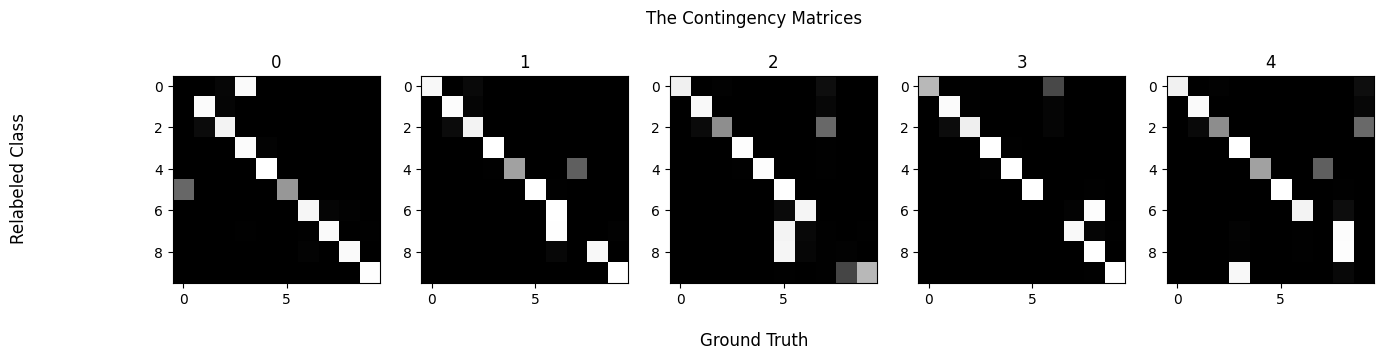

,Accuracy,ARI
0,0.840846,0.830970
1,0.844769,0.830582
2,0.711923,0.646562
3,0.853308,0.835986
4,0.698538,0.705537


In [200]:
accs_random, aris_random = problem_d('random')

# Problem (e)
Repeat point d) with five different k-means++ initializations (see the `sklearn.cluster.KMeans`
documentation for details). (1 point)

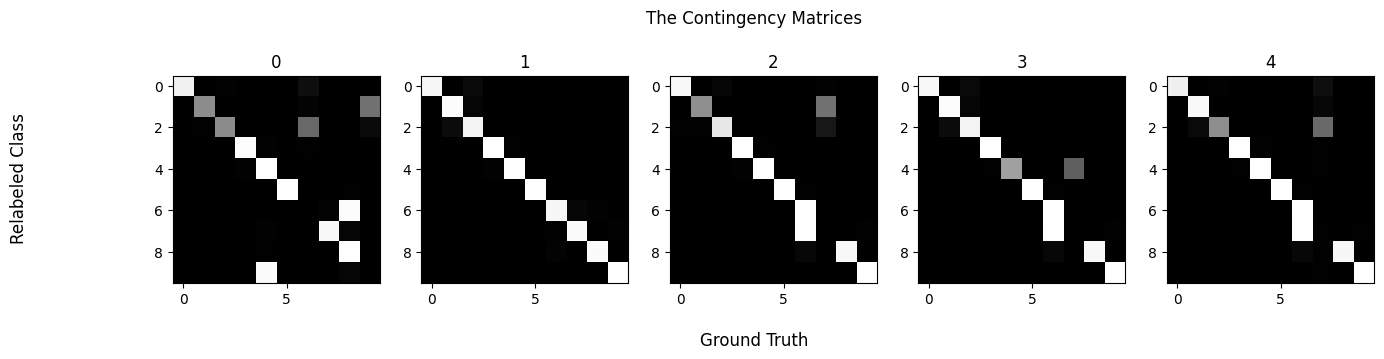

,Accuracy,ARI
0,0.693769,0.714590
1,0.977923,0.952099
2,0.834231,0.827276
3,0.844692,0.830797
4,0.836615,0.827301


In [201]:
accs_kpp, aris_kpp = problem_d('k-means++')

## Problem (f)
Implement the method for selecting k centers furthest from each other from page
29 of the LearningGM slides. Repeat point d) with five different instances of this
initialization method. (2 points)


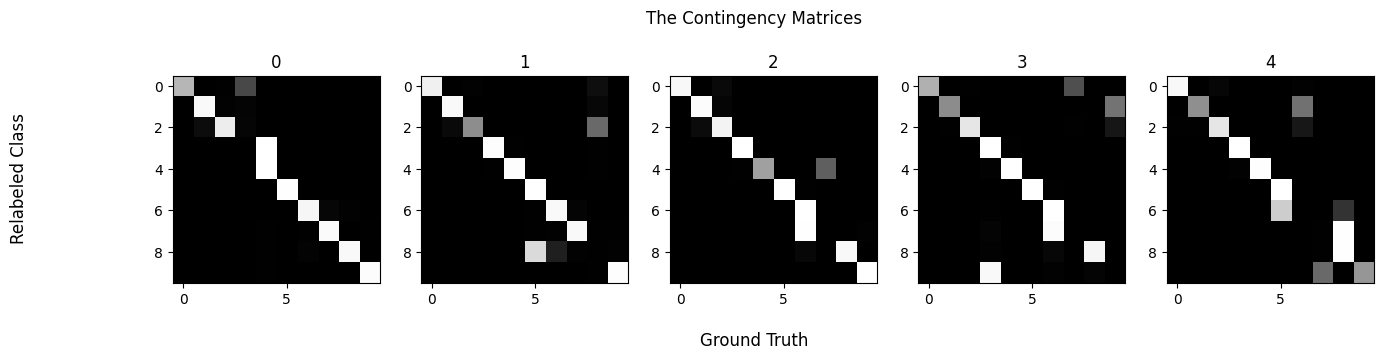

,Accuracy,ARI
0,0.851231,0.834414
1,0.836077,0.814536
2,0.844692,0.830797
3,0.705462,0.716990
4,0.697846,0.692198


In [202]:
accs_md, aris_md = problem_d('max-distance')

# Problem (f)
Report in a table the average accuracy scores and Adjusted Rand index scores
obtained at points d), e), f), where each average is computed from the five corresponding initializations. Which initialization method obtains the largest average
accuracy score and which obtains the largest average Adjusted Rand Index? (1
point)

In [204]:
data = {
    'random': [sum(accs_random)/5, sum(aris_random)/5],
    'k-means++': [sum(accs_kpp)/5, sum(aris_kpp)/5],
    'max-distance': [sum(accs_md)/5, sum(aris_md)/5]
}
display(pd.DataFrame(data, index = ['Average Accuracy', 'Average ARI']))

,random,k-means++,max-distance
Average Accuracy,0.789877,0.837446,0.787062
Average ARI,0.769927,0.830413,0.777787


We observe that `k-means++` performs the best.